# Part 1.3: Value Functions and Models

Welcome to the third and final notebook in our RL foundations series! In the previous notebooks, we learned what RL is and how policies work. Now we'll explore how to quantify "how good" states and actions are.

## Recap from Previous Notebooks

**Notebook 1.1 (Foundations):**
- RL agents learn through trial and error
- The Markov property: future depends only on present state
- FrozenLake: 4x4 grid with slippery ice, sparse rewards

**Notebook 1.2 (Policies & Exploration):**
- Policies map states to actions (deterministic or stochastic)
- ε-greedy balances exploration and exploitation
- Prediction evaluates policies; control finds optimal policies

## What This Notebook Covers
- **Value Functions**: Quantifying long-term desirability of states and actions
- **The Discount Factor γ**: Why we care more about sooner rewards
- **State Values V(s) and Action Values Q(s,a)**: Two perspectives on "goodness"
- **Models**: Representing environment dynamics (transitions and rewards)

## Preview: What Are Value Functions?

In Notebook 1.2, we talked about "good" and "bad" states informally. Value functions formalize this intuition by assigning a **single number** to each state (or state-action pair) that captures its **long-term desirability**.

For example, in FrozenLake:
- State 14 (adjacent to Goal) should have a **high value** — we're close to reward!
- State 5 (a Hole) should have **zero value** — the episode ends with no reward
- State 0 (Start) should have a **moderate value** — we can reach the Goal, but it's far away

Let's make this precise!

---
## Setup

In [1]:
# Install necessary libraries (uncomment if needed)
# !pip install gymnasium[toy-text] numpy matplotlib seaborn

In [2]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
import time

# Set style for plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Set random seed for reproducibility
np.random.seed(42)

print("Setup complete!")

Setup complete!


In [3]:
# Helper function for visualization
def visualize_value_function(V, title="State Value Function V(s)"):
    """Visualizes the value function as a heatmap on the FrozenLake grid."""
    V_grid = V.reshape((4, 4))
    
    fig, ax = plt.subplots(figsize=(7, 6))
    
    # Create heatmap
    im = sns.heatmap(V_grid, annot=True, fmt=".2f", cmap="Greens", 
                     cbar_kws={'label': 'Value'}, ax=ax,
                     linewidths=0.5, linecolor='gray')
    
    # Add cell labels (S, F, H, G)
    labels = [['S', 'F', 'F', 'F'],
              ['F', 'H', 'F', 'H'],
              ['F', 'F', 'F', 'H'],
              ['H', 'F', 'F', 'G']]
    
    for i in range(4):
        for j in range(4):
            ax.text(j + 0.5, i + 0.15, labels[i][j], 
                   ha='center', va='center', fontsize=10, 
                   color='red' if labels[i][j] == 'H' else 'blue',
                   fontweight='bold')
    
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_xlabel('Column')
    ax.set_ylabel('Row')
    
    plt.tight_layout()
    return fig, ax

---
# 1. Why Value Functions?

## The Problem with Raw Rewards

Consider FrozenLake: the reward is +1 at the Goal and 0 everywhere else. If we only look at immediate rewards:

- State 14 (adjacent to Goal): reward = 0
- State 0 (Start): reward = 0
- State 5 (Hole): reward = 0

They all look the same! But clearly state 14 is much better than state 5.

## Value Functions Capture Long-Term Thinking

Value functions solve this by answering: **"How much total reward can I expect from here, following some policy?"**

This incorporates:
- Future rewards (not just immediate)
- The policy being followed
- Uncertainty in transitions (stochastic environments)

## Two Types of Value Functions

| Function | Notation | Question It Answers |
|----------|----------|--------------------|
| **State Value** | $V^\pi(s)$ | "How good is it to BE in state $s$?" |
| **Action Value** | $Q^\pi(s,a)$ | "How good is it to DO action $a$ in state $s$?" |

Both are useful. $Q$ is especially powerful because it directly tells us which action is best!

---
# 2. The Discount Factor γ

Before defining value functions formally, we need to understand **discounting**.

## Why Discount Future Rewards?

Intuitively, we often prefer rewards sooner rather than later:

- **Uncertainty**: The future is uncertain; a reward now is guaranteed
- **Opportunity cost**: Money today can be invested for more money later
- **Mathematical convenience**: Prevents infinite returns in continuing tasks

## The Return $G_t$

The **return** is the total discounted reward from time $t$ onwards:

$$G_t = R_{t+1} + \gamma R_{t+2} + \gamma^2 R_{t+3} + \ldots = \sum_{k=0}^{\infty} \gamma^k R_{t+k+1}$$

where:
- $\gamma \in [0, 1]$: the **discount factor**
- $R_t$: the reward received at time $t$

## Effect of Different γ Values

| γ Value | Behavior | FrozenLake Impact |
|---------|----------|------------------|
| γ = 0 | Only care about immediate reward ("myopic") | Agent doesn't plan ahead at all |
| γ = 0.9 | Future rewards matter but are discounted | Reaching Goal in 5 steps worth $0.9^5 \approx 0.59$ |
| γ = 0.99 | Almost equal weighting of future | Reaching Goal in 5 steps worth $0.99^5 \approx 0.95$ |
| γ = 1 | All future rewards equally important | Works for episodic tasks like FrozenLake |

In [4]:
# Demonstrate the effect of discount factor
print("**Question this demonstration answers:** 'How does γ affect the value of delayed rewards?'\n")

def compute_return(rewards, gamma):
    """Compute the discounted return from a sequence of rewards."""
    G = 0
    for t, r in enumerate(rewards):
        G += (gamma ** t) * r
    return G

# Example: Rewards over 10 steps, with a big reward at the end
rewards = [0, 0, 0, 0, 0, 0, 0, 0, 0, 10]  # Reward of 10 at step 9
gammas = [0.0, 0.5, 0.9, 0.99, 1.0]

print("Effect of Discount Factor on Return")
print("=" * 50)
print(f"\nRewards: {rewards}")
print(f"(Big reward of 10 at the end, after 9 steps of 0)\n")

for gamma in gammas:
    G = compute_return(rewards, gamma)
    print(f"γ = {gamma:.2f}: Return G = {G:.4f}")
    if gamma > 0 and gamma < 1:
        print(f"         (10 × {gamma}^9 = 10 × {gamma**9:.6f} = {G:.4f})")

**Question this demonstration answers:** 'How does γ affect the value of delayed rewards?'

Effect of Discount Factor on Return

Rewards: [0, 0, 0, 0, 0, 0, 0, 0, 0, 10]
(Big reward of 10 at the end, after 9 steps of 0)

γ = 0.00: Return G = 0.0000
γ = 0.50: Return G = 0.0195
         (10 × 0.5^9 = 10 × 0.001953 = 0.0195)
γ = 0.90: Return G = 3.8742
         (10 × 0.9^9 = 10 × 0.387420 = 3.8742)
γ = 0.99: Return G = 9.1352
         (10 × 0.99^9 = 10 × 0.913517 = 9.1352)
γ = 1.00: Return G = 10.0000



**Question this plot answers:** 'How much is a future reward worth today?'



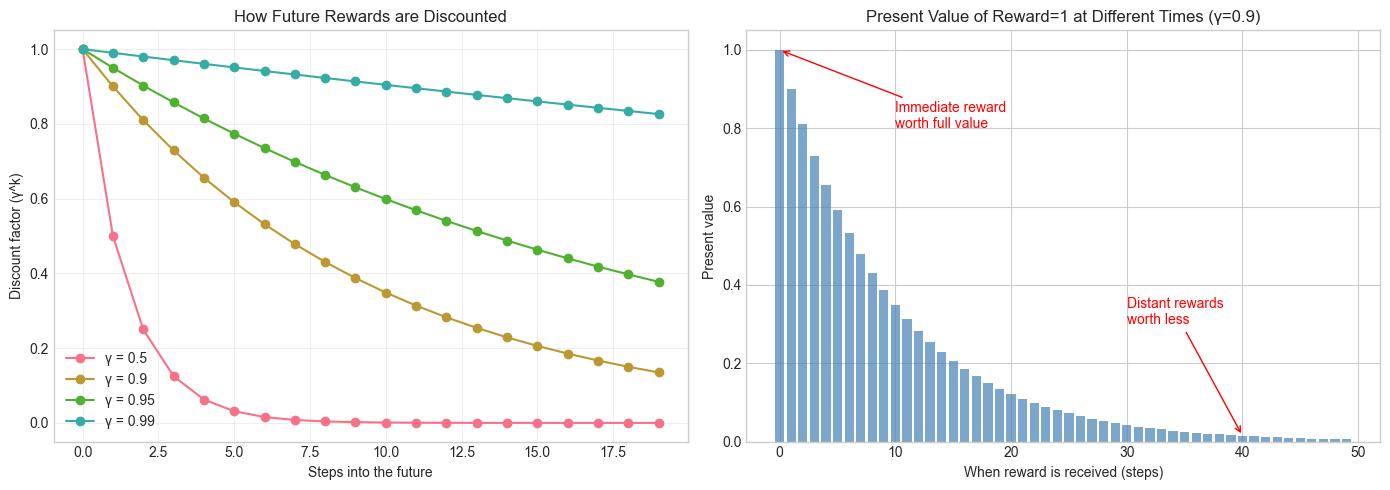

In [5]:
# Visualize discount factor effect
print("\n**Question this plot answers:** 'How much is a future reward worth today?'\n")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: How future rewards are discounted
steps = np.arange(0, 20)
gammas = [0.5, 0.9, 0.95, 0.99]

for gamma in gammas:
    discount_values = gamma ** steps
    axes[0].plot(steps, discount_values, 'o-', label=f'γ = {gamma}')

axes[0].set_xlabel('Steps into the future')
axes[0].set_ylabel('Discount factor (γ^k)')
axes[0].set_title('How Future Rewards are Discounted')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Present value of a reward of 1 at different future times
gamma = 0.9
future_times = np.arange(0, 50)
present_values = gamma ** future_times

axes[1].bar(future_times, present_values, color='steelblue', alpha=0.7)
axes[1].set_xlabel('When reward is received (steps)')
axes[1].set_ylabel('Present value')
axes[1].set_title(f'Present Value of Reward=1 at Different Times (γ={gamma})')

axes[1].annotate('Immediate reward\nworth full value', 
                xy=(0, 1), xytext=(10, 0.8),
                arrowprops=dict(arrowstyle='->', color='red'),
                fontsize=10, color='red')
axes[1].annotate('Distant rewards\nworth less', 
                xy=(40, 0.015), xytext=(30, 0.3),
                arrowprops=dict(arrowstyle='->', color='red'),
                fontsize=10, color='red')

plt.tight_layout()
plt.show()

> **Checkpoint — You should now understand:**
> - Why we discount future rewards (uncertainty, preference for sooner)
> - How the return $G_t$ is calculated
> - How different γ values affect the importance of future rewards

---
# 3. State-Value Function V(s)

The **state-value function** $V^\pi(s)$ tells us the expected return starting from state $s$ and following policy $\pi$:

$$V^\pi(s) = \mathbb{E}_\pi[G_t | S_t = s] = \mathbb{E}_\pi\left[\sum_{k=0}^{\infty} \gamma^k R_{t+k+1} \Big| S_t = s\right]$$

In plain English: **"How much total reward do I expect if I start here and follow this policy?"**

## V(s) in FrozenLake

What values would we expect for different states?

| State | Location | Expected V(s) | Reasoning |
|-------|----------|---------------|----------|
| **15 (Goal)** | G | 0 | Episode ends here - no future rewards to collect |
| **14** | Adjacent to Goal | High (~0.3-0.5) | One step from Goal, 1/3 chance of success per attempt |
| **5, 7, 11, 12** | Holes | 0 | Terminal states - episode ends with no reward |
| **0 (Start)** | S | Low (~0.01-0.1) | Far from Goal, must navigate past Holes |
| **10** | Near Goal | Medium (~0.2-0.4) | Close to Goal, relatively safe path available |

### Why Are Values So Low?

Even with a good policy, FrozenLake values are surprisingly low because:

1. **Slippery ice creates uncertainty** - You only move in your intended direction 1/3 of the time
2. **Holes are deadly** - One wrong slip and the episode ends with 0 reward
3. **Compounding probability** - Even if each step has 50% success rate, 6 steps means $0.5^6 \approx 1.5\%$ overall success

**Question this heatmap answers:** 'Which states are most valuable in FrozenLake?'



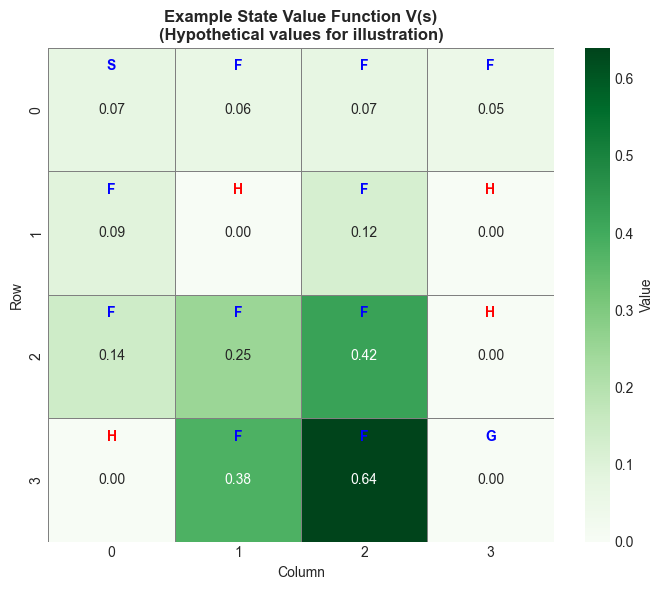


This heatmap shows what a learned Value Function might look like:
- Green = higher value (better states)
- White = lower value (worse states)
- Holes (H) and Goal (G) have value 0 (terminal states)
- States closer to the Goal have higher values


In [6]:
# Example: Hypothetical value function (what we'd expect from a reasonable policy)
print("**Question this heatmap answers:** 'Which states are most valuable in FrozenLake?'\n")

# Higher values near the goal, zero at holes and goal (terminal states)
hypothetical_V = np.array([
    0.07, 0.06, 0.07, 0.05,  # Top row - far from goal, low values
    0.09, 0.00, 0.12, 0.00,  # Second row - holes have 0
    0.14, 0.25, 0.42, 0.00,  # Third row - getting closer to goal
    0.00, 0.38, 0.64, 0.00   # Bottom row - hole at 12, high values near goal, 0 at goal
])

visualize_value_function(hypothetical_V, "Example State Value Function V(s)\n(Hypothetical values for illustration)")
plt.show()

print("\nThis heatmap shows what a learned Value Function might look like:")
print("- Green = higher value (better states)")
print("- White = lower value (worse states)")
print("- Holes (H) and Goal (G) have value 0 (terminal states)")
print("- States closer to the Goal have higher values")

> **Checkpoint — You should now understand:**
> - What $V^\pi(s)$ represents (expected return from state s under policy π)
> - Why terminal states (Goal, Holes) have value 0
> - Why states closer to the Goal have higher values

---
# 4. Action-Value Function Q(s,a)

The **action-value function** $Q^\pi(s,a)$ tells us the expected return starting from state $s$, taking action $a$, and then following policy $\pi$:

$$Q^\pi(s,a) = \mathbb{E}_\pi[G_t | S_t = s, A_t = a]$$

In plain English: **"How much total reward do I expect if I take this specific action here, then follow the policy?"**

## V vs Q: What's the Difference?

| Aspect | V(s) | Q(s,a) |
|--------|------|--------|
| **Inputs** | Just state | State AND action |
| **Question** | "How good is this state?" | "How good is this action in this state?" |
| **Size** | One value per state | One value per state-action pair |
| **FrozenLake** | 16 values (one per cell) | 64 values (4 actions × 16 cells) |

## Why Q is Especially Useful

The action-value function directly tells us which action is best:

$$\pi^*(s) = \arg\max_a Q^*(s, a)$$

If we know the optimal Q-function $Q^*$, we immediately know the optimal policy!

## Q vs V: A FrozenLake Example

Consider **state 10** (one step above and left of the Goal):

**State value V(10):** ~0.42 (average across all actions)

**Action values Q(10, a):**

| Action | Q(10, a) | Why |
|--------|----------|-----|
| LEFT | ~0.25 | Moves away from Goal |
| DOWN | ~0.55 | Moves toward Goal! |
| RIGHT | ~0.20 | Risk of Hole at state 11 |
| UP | ~0.15 | Moves away from Goal |

**Key insight:** Q-values show that DOWN is clearly the best action, while V only gives us the average.

**Question this visualization answers:** 'Which action is best in state 10?'



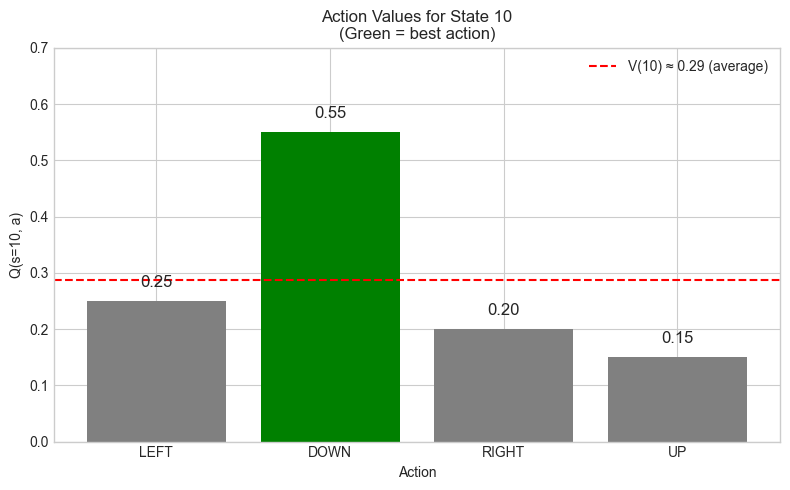


Best action in state 10: DOWN (Q = 0.55)
State value V(10) ≈ 0.29 (average of Q-values under policy)


In [7]:
# Visualize Q-values for a specific state
print("**Question this visualization answers:** 'Which action is best in state 10?'\n")

# Hypothetical Q-values for state 10
Q_state_10 = {
    'LEFT': 0.25,
    'DOWN': 0.55,
    'RIGHT': 0.20,
    'UP': 0.15
}

fig, ax = plt.subplots(figsize=(8, 5))

actions = list(Q_state_10.keys())
values = list(Q_state_10.values())
colors = ['gray', 'green', 'gray', 'gray']  # Highlight best action

bars = ax.bar(actions, values, color=colors)
ax.set_ylabel('Q(s=10, a)')
ax.set_xlabel('Action')
ax.set_title('Action Values for State 10\n(Green = best action)')
ax.set_ylim(0, 0.7)

# Add value labels
for bar, val in zip(bars, values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
            f'{val:.2f}', ha='center', va='bottom', fontsize=12)

# Add V(s) reference line
V_s = np.mean(values)
ax.axhline(y=V_s, color='red', linestyle='--', label=f'V(10) ≈ {V_s:.2f} (average)')
ax.legend()

plt.tight_layout()
plt.show()

print(f"\nBest action in state 10: DOWN (Q = {Q_state_10['DOWN']:.2f})")
print(f"State value V(10) ≈ {V_s:.2f} (average of Q-values under policy)")

## The Relationship Between V and Q

V and Q are related through the policy:

$$V^\pi(s) = \sum_a \pi(a|s) \cdot Q^\pi(s,a)$$

In words: The state value is the weighted average of action values, weighted by the policy.

For a **deterministic policy** that always chooses action $a^*$:
$$V^\pi(s) = Q^\pi(s, a^*)$$

For a **uniform random policy** (equal probability for all actions):
$$V^\pi(s) = \frac{1}{|A|} \sum_a Q^\pi(s,a)$$

> **Checkpoint — You should now understand:**
> - What $Q^\pi(s,a)$ represents (expected return after taking action a in state s)
> - Why Q is useful for finding optimal actions: $\pi^*(s) = \arg\max_a Q^*(s,a)$
> - How V and Q are related through the policy

---
# 5. Models of the Environment

A **model** predicts what the environment will do next. It consists of two parts:

## 5.1 Transition Model (Dynamics)

$$P(s'|s,a) = P[S_{t+1} = s' | S_t = s, A_t = a]$$

The probability of ending up in state $s'$ after taking action $a$ in state $s$.

## 5.2 Reward Model

$$R(s,a) = \mathbb{E}[R_{t+1} | S_t = s, A_t = a]$$

The expected reward after taking action $a$ in state $s$.

## Why Models Matter

Having a model allows the agent to **plan ahead** without actually taking actions:

- "If I go RIGHT, I'll probably end up in state 10... and from there..."
- This is called **model-based RL**

Without a model, the agent must learn purely from experience:
- "Last time I went RIGHT, I ended up in state 10 and got reward 0"
- This is called **model-free RL**

## 🔍 Instructor-Only Knowledge vs 🤖 Agent-Visible Information

**Important distinction for learning RL:**

| Symbol | Meaning | Example |
|--------|---------|----------|
| 🔍 | **Instructor-only** - We (the tutorial) know this, but a real agent wouldn't | Accessing `env.unwrapped.P` to see transition probabilities |
| 🤖 | **Agent-visible** - The agent can observe this through interaction | Current state, received rewards, outcomes of actions |

In the code below, we'll peek at FrozenLake's internal model. Remember: a real RL agent would need to **learn** this through trial and error!

In [8]:
# 🔍 INSTRUCTOR-ONLY: Access FrozenLake's transition model
# A real agent would NOT have access to this - it would learn through experience!

env = gym.make("FrozenLake-v1", is_slippery=True)
env.reset()

print("🔍 INSTRUCTOR-ONLY: FrozenLake Transition Model")
print("=" * 50)
print("\n⚠️  Note: A real RL agent does NOT have access to this!")
print("    This is for educational purposes only.\n")
print("Format: env.unwrapped.P[state][action] = list of (probability, next_state, reward, done)")

# Example: Show transitions from state 0
state = 0
action_names = {0: 'LEFT', 1: 'DOWN', 2: 'RIGHT', 3: 'UP'}

print(f"\n--- Transitions from State {state} (top-left corner) ---")
for action in range(4):
    print(f"\nAction {action} ({action_names[action]}):")
    for prob, next_state, reward, done in env.unwrapped.P[state][action]:
        if prob > 0:
            print(f"  → State {next_state} with probability {prob:.2f}, reward={reward}, done={done}")

env.close()

🔍 INSTRUCTOR-ONLY: FrozenLake Transition Model

⚠️  Note: A real RL agent does NOT have access to this!
    This is for educational purposes only.

Format: env.unwrapped.P[state][action] = list of (probability, next_state, reward, done)

--- Transitions from State 0 (top-left corner) ---

Action 0 (LEFT):
  → State 0 with probability 0.33, reward=0, done=False
  → State 0 with probability 0.33, reward=0, done=False
  → State 4 with probability 0.33, reward=0, done=False

Action 1 (DOWN):
  → State 0 with probability 0.33, reward=0, done=False
  → State 4 with probability 0.33, reward=0, done=False
  → State 1 with probability 0.33, reward=0, done=False

Action 2 (RIGHT):
  → State 4 with probability 0.33, reward=0, done=False
  → State 1 with probability 0.33, reward=0, done=False
  → State 0 with probability 0.33, reward=0, done=False

Action 3 (UP):
  → State 1 with probability 0.33, reward=0, done=False
  → State 0 with probability 0.33, reward=0, done=False
  → State 0 with probabi

**Question this plot answers:** 'Where might I end up if I try to go RIGHT from state 6?'



/var/folders/p9/yfdwydy169s3mz1hd23bwrtw0000gn/T/ipykernel_15628/850471847.py:61: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) Arial.
  plt.tight_layout()
/Users/tothi/pysrc/reinforcement_learning_tutorial/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


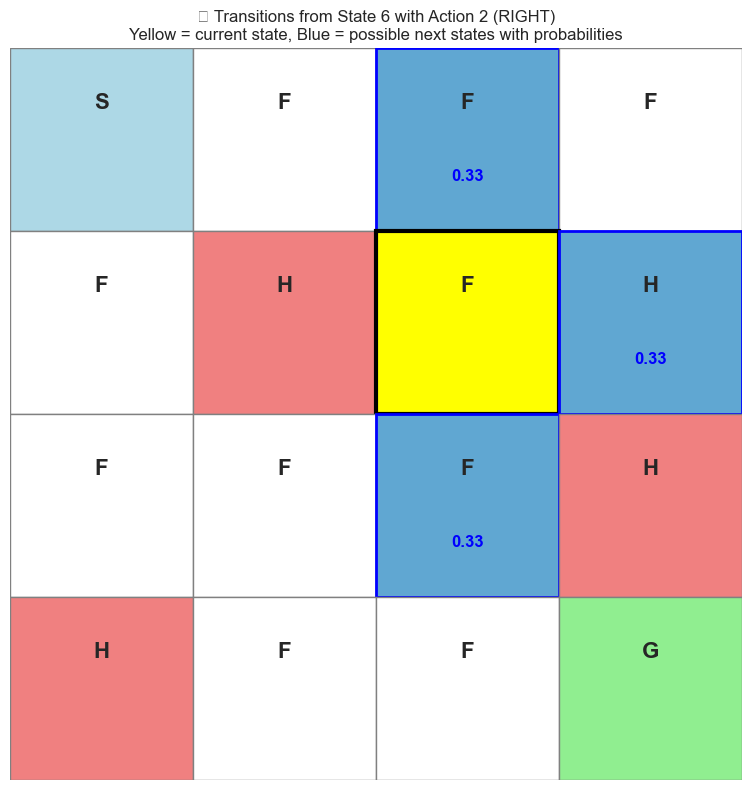


⚠️  Notice: Due to the slippery ice, trying to go RIGHT from state 6
   can result in going RIGHT, UP, or DOWN with equal probability (1/3 each)!


In [9]:
# 🔍 INSTRUCTOR-ONLY: Visualize transition probabilities
env = gym.make("FrozenLake-v1", is_slippery=True)
env.reset()

def visualize_transitions(env, state, action):
    """Visualize the transition probabilities from a state given an action."""
    desc = env.unwrapped.desc.astype(str)
    nrow, ncol = desc.shape
    
    fig, ax = plt.subplots(figsize=(8, 8))
    
    colors = {'S': 'lightblue', 'F': 'white', 'H': 'lightcoral', 'G': 'lightgreen'}
    
    # Get transition probabilities
    transitions = env.unwrapped.P[state][action]
    trans_dict = {next_s: prob for prob, next_s, _, _ in transitions if prob > 0}
    
    # Draw the grid
    for i in range(nrow):
        for j in range(ncol):
            cell = desc[i, j]
            state_idx = i * ncol + j
            
            base_color = colors.get(cell, 'white')
            
            if state_idx == state:
                facecolor = 'yellow'
                edgecolor = 'black'
                linewidth = 3
            elif state_idx in trans_dict:
                prob = trans_dict[state_idx]
                facecolor = plt.cm.Blues(0.3 + 0.7 * prob)
                edgecolor = 'blue'
                linewidth = 2
            else:
                facecolor = base_color
                edgecolor = 'gray'
                linewidth = 1
            
            rect = plt.Rectangle((j, nrow-1-i), 1, 1, fill=True,
                                 facecolor=facecolor, edgecolor=edgecolor, linewidth=linewidth)
            ax.add_patch(rect)
            
            ax.text(j + 0.5, nrow - 1 - i + 0.7, cell,
                   ha='center', va='center', fontsize=16, fontweight='bold')
            
            if state_idx in trans_dict:
                ax.text(j + 0.5, nrow - 1 - i + 0.3, f'{trans_dict[state_idx]:.2f}',
                       ha='center', va='center', fontsize=12, color='blue', fontweight='bold')
    
    ax.set_xlim(0, ncol)
    ax.set_ylim(0, nrow)
    ax.set_aspect('equal')
    ax.axis('off')
    
    action_names = {0: 'LEFT', 1: 'DOWN', 2: 'RIGHT', 3: 'UP'}
    ax.set_title(f'🔍 Transitions from State {state} with Action {action} ({action_names[action]})\n'
                f'Yellow = current state, Blue = possible next states with probabilities',
                fontsize=12)
    
    plt.tight_layout()
    return fig, ax

print("**Question this plot answers:** 'Where might I end up if I try to go RIGHT from state 6?'\n")

visualize_transitions(env, state=6, action=2)  # RIGHT
plt.show()

print("\n⚠️  Notice: Due to the slippery ice, trying to go RIGHT from state 6")
print("   can result in going RIGHT, UP, or DOWN with equal probability (1/3 each)!")

env.close()

## The Reward Model in FrozenLake

While the transition model tells us **where** we might end up, the reward model tells us **what reward** we'll receive.

### FrozenLake's Reward Structure

| Current State | Next State | Reward |
|--------------|------------|--------|
| Any state | Goal (15) | +1 |
| Any state | Hole (5, 7, 11, 12) | 0 |
| Any state | Any other state | 0 |

### Expected Reward for Each State-Action Pair

Since the reward depends on **where we end up**, we need to consider all possible transitions:

$$R(s,a) = \sum_{s'} P(s'|s,a) \cdot R(s, a, s')$$

**Example: State 14, Action RIGHT**

From state 14, if we choose RIGHT:
- 1/3 chance → State 15 (Goal) → Reward = +1
- 1/3 chance → State 10 (slip UP) → Reward = 0  
- 1/3 chance → State 14 (slip DOWN, hits wall) → Reward = 0

Expected reward: $R(14, RIGHT) = \frac{1}{3}(1) + \frac{1}{3}(0) + \frac{1}{3}(0) = \frac{1}{3} \approx 0.33$

### Why Sparse Rewards Make Learning Hard

FrozenLake has **sparse rewards**:

| Situation | Expected Reward | Why Learning is Hard |
|-----------|-----------------|---------------------|
| Far from Goal | 0 | No feedback about whether actions are good |
| Adjacent to Goal | ~0.33 | Only 1/3 chance of getting +1 |
| Next to Hole | 0 | No penalty for falling in! |

The agent must learn through **rare successes** which action sequences lead to the Goal.

> **Checkpoint — You should now understand:**
> - What transition models P(s'|s,a) and reward models R(s,a) represent
> - The difference between 🔍 instructor knowledge and 🤖 agent knowledge
> - Why FrozenLake's sparse rewards make learning challenging

---
# 6. Summary: How Everything Fits Together

We've now covered all the foundational concepts of Reinforcement Learning. Here's how they all connect:

```
REINFORCEMENT LEARNING: THE COMPLETE PICTURE
=============================================

                    ┌─────────────────────────────────────┐
                    │           ENVIRONMENT               │
                    │                                     │
                    │  ┌─────────────────────────────┐    │
                    │  │      MODEL (optional)       │    │
                    │  │  • Transitions P(s'|s,a)    │    │
                    │  │  • Rewards R(s,a)           │    │
                    │  └─────────────────────────────┘    │
                    │                                     │
                    │   States s, Rewards r               │
                    └──────────────┬──────────────────────┘
                                   │
                                   ▼
                    ┌─────────────────────────────────────┐
                    │             AGENT                   │
                    │                                     │
                    │  ┌──────────────────────────────┐   │
                    │  │         POLICY π             │   │
                    │  │   Maps states to actions     │   │
                    │  │   π(a|s) or π(s) = a         │   │
                    │  └──────────────────────────────┘   │
                    │              ▲                      │
                    │              │ improves             │
                    │              │                      │
                    │  ┌──────────────────────────────┐   │
                    │  │     VALUE FUNCTIONS          │   │
                    │  │   V(s): How good is state    │   │
                    │  │   Q(s,a): How good is action │   │
                    │  └──────────────────────────────┘   │
                    │                                     │
                    │   Actions a                         │
                    └──────────────┬──────────────────────┘
                                   │
                                   ▼
                              ENVIRONMENT


KEY CONCEPTS:
─────────────
• MARKOV PROPERTY: Future depends only on present state
• DISCOUNT γ: Future rewards worth less than immediate
• EXPLORATION vs EXPLOITATION: Try new vs use known
• PREDICTION vs CONTROL: Evaluate vs optimize policy


THE LEARNING LOOP:
──────────────────
1. Agent observes state s
2. Agent chooses action a using policy π (with exploration)
3. Environment returns next state s' and reward r
4. Agent updates value estimates V or Q
5. Agent improves policy based on values
6. Repeat until policy converges to optimal π*
```

## What's Coming Next

In the next notebooks, we'll learn **algorithms** that implement this learning loop:

| Notebook | Topic | What You'll Learn |
|----------|-------|------------------|
| **02** | MDPs & Bellman Equations | Mathematical foundation for value functions |
| **03** | Dynamic Programming | Algorithms when you have the model |
| **04** | Monte Carlo Methods | Learning from complete episodes |
| **05** | TD Learning | Learning from incomplete episodes |
| **06** | Q-Learning & SARSA | Model-free control algorithms |

---
# 7. Your Turn

## Exercise 1: Compute Expected Rewards

Using the transition model from `env.unwrapped.P`, compute the expected immediate reward for state 14 taking action RIGHT (toward the Goal).

**Recall:** $R(s,a) = \sum_{s'} P(s'|s,a) \cdot R(s,a,s')$

**Why this matters:** This calculation is at the heart of the Bellman equation, which you'll learn in the next notebook. Understanding it now will make those concepts much clearer!

In [10]:
# YOUR CODE HERE
# Uncomment and complete the code below

# env = gym.make("FrozenLake-v1", is_slippery=True)
# env.reset()

# state = 14
# action = 2  # RIGHT

# # Get transitions for this state-action pair
# transitions = env.unwrapped.P[state][action]

# # Calculate expected reward
# expected_reward = 0
# print(f"Transitions from state {state} with action RIGHT:")
# for prob, next_state, reward, done in transitions:
#     print(f"  P(s'={next_state}) = {prob:.2f}, R = {reward}")
#     # TODO: Add to expected_reward
#     # expected_reward += ...

# print(f"\nExpected reward R({state}, RIGHT) = {expected_reward:.4f}")
# env.close()

## Exercise 2: Conceptual Question

Consider two states in FrozenLake:
- State 10: V(10) = 0.42
- State 14: V(14) = 0.64

**Question:** Suppose the agent is in state 10 and takes action DOWN, ending up in state 14. Does this mean the agent "gained" 0.22 value (= 0.64 - 0.42)? Why or why not?

<details>
<summary>Click to see answer</summary>

**No, the agent did not "gain" value by moving!**

Here's why:

1. **V(s) includes future expectations**: V(10) = 0.42 already accounts for the possibility of reaching state 14 and eventually getting the reward. The value is an expectation over all possible futures.

2. **One transition doesn't change true value**: The environment's dynamics don't change. V(10) = 0.42 was correct before the move and would be correct again if the agent returned to state 10.

3. **What actually happened**: The agent transitioned from state 10 to state 14. Before the move, the expected return was V(10) = 0.42. After arriving at state 14, the expected remaining return is V(14) = 0.64. The difference reflects that:
   - The agent got "lucky" (moved in the intended direction)
   - One step of uncertainty was resolved favorably

4. **If we kept track of returns**: The actual return the agent will receive from state 10 might be 0 (fell in hole later), 1 (reached goal), or something in between when discounted. V(10) = 0.42 is just the expected value averaged over many episodes.

This is a subtle but important point about value functions!

</details>

**Congratulations! You've completed Part 1 of the RL Tutorial!**

You now understand the foundational concepts:
- What RL is and how agents interact with environments
- Policies (deterministic and stochastic)
- Value functions V(s) and Q(s,a)
- The discount factor γ
- Models (transition and reward)
- Exploration vs exploitation
- Prediction vs control

Next: 02_mdp_and_bellman.ipynb - The mathematical foundations!